<a href="https://colab.research.google.com/github/tanmayyg/micrograd/blob/main/Micrograd_andrew_lec1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import math
import matplotlib.pyplot as plt
import random


In [ ]:
# prompt: I want a code to represent this network of Value nodes that I have created

# !pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular node for it
    dot.node(name = uid, label = "{ %s|data %.4f| grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this op node to the value node
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# draw_dot(e)

In [ ]:
print('cuda' if torch.cuda.is_available else 'cpu')

cuda


In [ ]:
class Value:
  def __init__(self,data, _children = (), _op="", label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, _children = (self,other), _op="+")
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, _children = (self,other), _op="*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rsub__(self, other):
    return -1*(self - other)

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __pow__(self,other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    # other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data ** other, _children = (self,), _op="**")
    def _backward():
      self.grad += (other * (self.data ** (other - 1))) * out.grad
      # other.grad += (out.data * math.log(self.data)) * out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children = (self,), _op="tanh")
    def _backward():
      self.grad += ((1 - t**2) * out.grad)
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), _children = (self,), _op="exp")
    def _backward():
      self.grad += (out.data * out.grad)
    out._backward = _backward
    return out



  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1
    for neuron in reversed(topo):
      neuron._backward()




In [ ]:
a = Value(5)
b = Value(4)
a + (-1*-b)

Value(data=9)

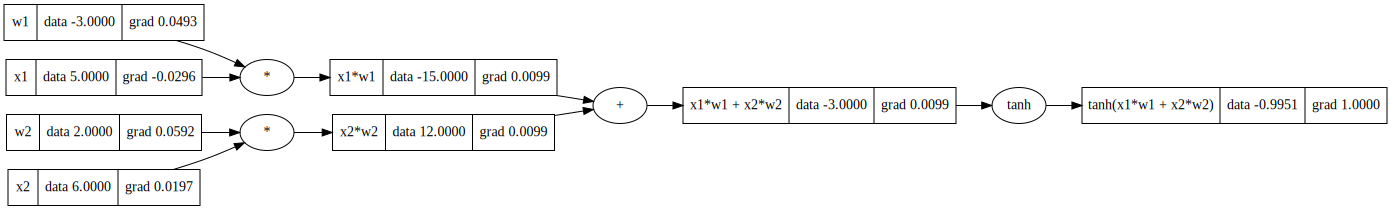

In [ ]:
x1 = Value(5, label = 'x1')
x2 = Value(6, label = 'x2')
w1 = Value(-3, label = 'w1')
w2 = Value(2, label = 'w2')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2.tanh(); n.label = 'tanh(x1*w1 + x2*w2)'
n.backward()
draw_dot(n)
# e = (2*n).exp(); e.label = 'e(2*n)'

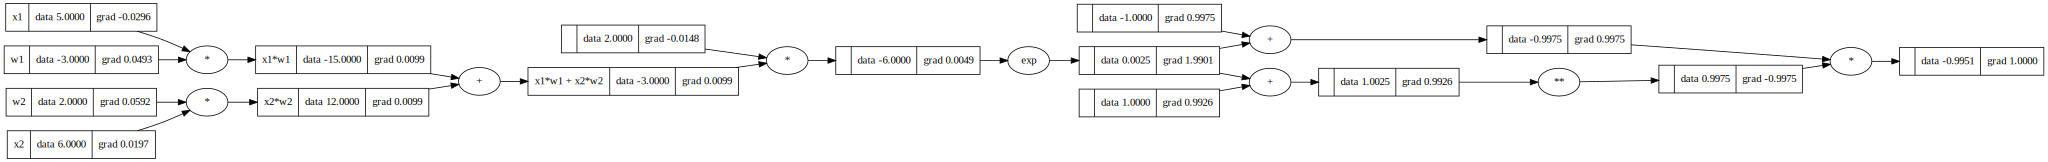

In [ ]:
x1 = Value(5, label = 'x1')
x2 = Value(6, label = 'x2')
w1 = Value(-3, label = 'w1')
w2 = Value(2, label = 'w2')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

e = (2*x1w1x2w2).exp()
n = (e-1)/(e + 1)

n.backward()
draw_dot(n)

# n = x1w1x2w2.tanh(); n.label = 'tanh(x1*w1 + x2*w2)'
# e = (2*n).exp(); e.label = 'e(2*n)'

###Implementing Neural Network

In [ ]:
class Neuron:
  def __init__(self, n):
    self.w = [Value(random.uniform(-0.1,0.1)) for _ in range(n)] # Reduced initialization range
    self.b = Value(random.uniform(-0.1,0.1)) # Reduced initialization range

  def __call__(self,x):
    act =  sum((val[0]*val[1] for val in zip(self.w,x)), self.b)
    return act.tanh()

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, num_input,num_output):
    self.neurons = [Neuron(num_input) for _ in range(num_output)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, num_input,num_output_list):
    temp_list = [num_input] + num_output_list
    self.layers = [Layer(ni,no) for ni,no in zip(temp_list,temp_list[1:])]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [598]:
m = MLP(3,[4,4,1])
xs = [[2.0,0.5,0.8],[0.5,2.5,-2.0],[-1.0,-2.0,2.0], [-1.0,1.0,2.0]]
ys = [1.0,-1.0,-2.0,1.0]

In [599]:
for n in range(100):
  ypred = [m(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
  for param in m.parameters():
    param.grad = 0
  loss.backward()
  for param in m.parameters():
    param.data += (-0.1 * param.grad)

  print(loss)

Value(data=6.8412443560694)
Value(data=6.744368815985896)
Value(data=6.735048583378008)
Value(data=6.726640487725043)
Value(data=6.714590359839734)
Value(data=6.695741447369065)
Value(data=6.664313350353369)
Value(data=6.60840410025871)
Value(data=6.501974921999329)
Value(data=6.2861602420157165)
Value(data=5.836044332556554)
Value(data=4.97921986946279)
Value(data=3.731653316338085)
Value(data=2.424043826408198)
Value(data=2.6245592556611745)
Value(data=6.243898547333393)
Value(data=5.234621965533603)
Value(data=1.2272472437737223)
Value(data=1.1568838083383297)
Value(data=1.1173273146985174)
Value(data=1.0969468614564297)
Value(data=1.082657408466721)
Value(data=1.072034554309191)
Value(data=1.063816439635921)
Value(data=1.0572663604031942)
Value(data=1.0519226687997)
Value(data=1.047480426526259)
Value(data=1.04372975065127)
Value(data=1.0405213068859356)
Value(data=1.0377458832145416)
Value(data=1.035321738102342)
Value(data=1.0331864644970263)
Value(data=1.031291589295966)
Value(d

In [ ]:
ypred

[[Value(data=-0.0715581354991991),
  Value(data=-0.07422404828707779),
  Value(data=-0.052447960161407556)]]